# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 26
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

# Models

## Simple Poisson model

### Preparing data

In [17]:
spm_df = element_gameweek_df.copy()

In [18]:
spm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [19]:
spm_df = player.remove_redundant_columns(spm_df, spm_redundant_columns)

In [20]:
spm_response_df, spm_explanatory_df = player.get_response_explanatory_dfs(spm_df, 'assists')

In [21]:
spm_explanatory_df.columns

Index(['const'], dtype='object')

In [22]:
spm_response_df.head()

76    0
78    0
79    0
80    0
81    0
Name: assists, dtype: int64

### Fitting model

In [23]:
spm_results = sm.GLM(
    spm_response_df,
    spm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [24]:
print(spm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6674
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2175.1
Date:                Sat, 16 Mar 2019   Deviance:                       3144.7
Time:                        16:03:10   Pearson chi2:                 7.16e+03
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3462      0.040    -59.309      0.000      -2.424      -2.269


### Model fit

In [25]:
spm_results.aic

4352.178364133257

In [26]:
spm_results.bic

-55627.337998279516

In [27]:
spm_pearson_results = goodness_fit.pearson_chi_squared_test(spm_results)
spm_pearson_results

(True, 1.671410863912648e-05)

In [28]:
spm_results.resid_deviance.describe()

count    6675.000000
mean       -0.240530
std         0.642907
min        -0.437562
25%        -0.437562
50%        -0.437562
75%        -0.437562
max         3.854926
dtype: float64

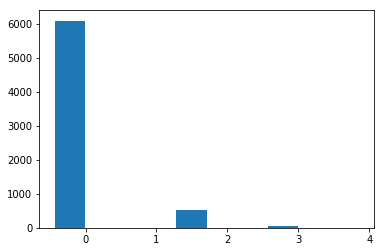

In [29]:
plt.figure()
plt.hist(spm_results.resid_deviance)
plt.show()

## Simple Poisson minutes model

### Preparing data

In [30]:
spmm_df = element_gameweek_df.copy()

In [31]:
spmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [32]:
spmm_df['log_minutes'] = np.log(spmm_df['minutes'])

In [33]:
spmm_df = player.remove_redundant_columns(spmm_df, spmm_redundant_columns)

In [34]:
spmm_response_df, spmm_explanatory_df = player.get_response_explanatory_dfs(spmm_df, 'assists')

In [35]:
spmm_explanatory_df.columns

Index(['const', 'log_minutes'], dtype='object')

### Fitting model

In [36]:
spmm_results = sm.GLM(
    spmm_response_df,
    spmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [37]:
print(spmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6673
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2137.7
Date:                Sat, 16 Mar 2019   Deviance:                       3069.9
Time:                        16:03:11   Pearson chi2:                 6.98e+03
No. Iterations:                     6                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.5608      0.322    -14.161      0.000      -5.192      -3.930
log_minutes     0.5306      0.075      7.112     

### Model fit

In [38]:
spmm_results.aic

4279.310891747676

In [39]:
spmm_results.bic

-55693.399346181825

In [40]:
spmm_pearson_results = goodness_fit.pearson_chi_squared_test(spmm_results)
spmm_pearson_results

(True, 0.004605590251514968)

In [41]:
spmm_results.resid_deviance.describe()

count    6675.000000
mean       -0.234544
std         0.636361
min        -0.477113
25%        -0.477113
50%        -0.477113
75%        -0.346657
max         3.722663
dtype: float64

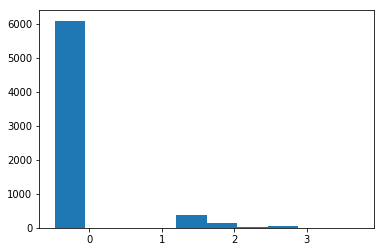

In [42]:
plt.figure()
plt.hist(spmm_results.resid_deviance)
plt.show()

## Simple Poisson teams model

### Preparing data

In [43]:
sptm_df = element_gameweek_df.copy()

In [44]:
sptm_df = player.add_categorical_variables(sptm_df, 'element_type')
sptm_df = player.add_categorical_variables(sptm_df, 'opposition_team')
sptm_df = player.add_categorical_variables(sptm_df, 'own_team')

In [45]:
sptm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [46]:
sptm_df = player.remove_redundant_columns(sptm_df, sptm_redundant_columns)

In [47]:
sptm_response_df, sptm_explanatory_df = player.get_response_explanatory_dfs(sptm_df, 'assists')

In [48]:
sptm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [49]:
sptm_response_df.head()

76    0
78    0
79    0
80    0
81    0
Name: assists, dtype: int64

### Fitting model

In [50]:
sptm_results = sm.GLM(
    sptm_response_df,
    sptm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [51]:
print(sptm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6633
Model Family:                 Poisson   Df Model:                           41
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2078.0
Date:                Sat, 16 Mar 2019   Deviance:                       2950.6
Time:                        16:03:12   Pearson chi2:                 6.87e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3836      0.247     -9.647      0.000      -2.868      -1.899
was_home               0.150

### Model fit

In [52]:
sptm_results.aic

4240.051792760612

In [53]:
sptm_results.bic

-55460.41346583815

In [54]:
sptm_pearson_results = goodness_fit.pearson_chi_squared_test(sptm_results)
sptm_pearson_results

(True, 0.022029767090219976)

In [55]:
sptm_results.resid_deviance.describe()

count    6675.000000
mean       -0.227671
std         0.624710
min        -0.878901
25%        -0.479601
50%        -0.392214
75%        -0.303197
max         3.608517
dtype: float64

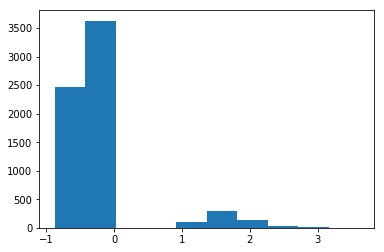

In [56]:
plt.figure()
plt.hist(sptm_results.resid_deviance)
plt.show()

## Simple Poisson teams minutes model

### Preparing data

In [57]:
sptmm_df = element_gameweek_df.copy()

In [58]:
sptmm_df = player.add_categorical_variables(sptmm_df, 'element_type')
sptmm_df = player.add_categorical_variables(sptmm_df, 'opposition_team')
sptmm_df = player.add_categorical_variables(sptmm_df, 'own_team')

In [59]:
sptmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes'
]

In [60]:
sptmm_df['log_minutes'] = np.log(sptmm_df['minutes'])

In [61]:
sptmm_df = player.remove_redundant_columns(sptmm_df, sptmm_redundant_columns)

In [62]:
sptmm_response_df, sptmm_explanatory_df = player.get_response_explanatory_dfs(sptmm_df, 'assists')

In [63]:
sptmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [64]:
sptmm_results = sm.GLM(
    sptmm_response_df,
    sptmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [65]:
print(sptmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6632
Model Family:                 Poisson   Df Model:                           42
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2022.7
Date:                Sat, 16 Mar 2019   Deviance:                       2840.0
Time:                        16:03:13   Pearson chi2:                 6.70e+03
No. Iterations:                     6                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.3505      0.434    -12.333      0.000      -6.201      -4.500
was_home               0.146

### Model fit

In [66]:
sptmm_results.aic

4131.430362795217

In [67]:
sptmm_results.bic

-55562.22877132028

In [68]:
sptmm_pearson_results = goodness_fit.pearson_chi_squared_test(sptmm_results)
sptmm_pearson_results

(False, 0.28194871722764203)

In [69]:
sptmm_results.resid_deviance.describe()

count    6675.000000
mean       -0.219586
std         0.614252
min        -0.971712
25%        -0.476253
50%        -0.371393
75%        -0.269480
max         3.525835
dtype: float64

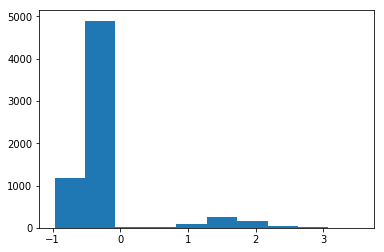

In [70]:
plt.figure()
plt.hist(sptmm_results.resid_deviance)
plt.show()

## Simple Poisson player model

### Preparing data

In [71]:
sppm_df = element_gameweek_df.copy()

In [72]:
sppm_df = player.add_categorical_variables(sppm_df, 'opposition_team')
sppm_df = player.add_categorical_variables(sppm_df, 'element')

In [73]:
sppm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [74]:
sppm_df = player.remove_redundant_columns(sppm_df, sppm_redundant_columns)

In [75]:
sppm_response_df, sppm_explanatory_df = player.get_response_explanatory_dfs(sppm_df, 'assists')

In [76]:
sppm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_580', 'element_581', 'element_585', 'element_586',
       'element_587', 'element_588', 'element_589', 'element_590',
       'element_591', 'element_592'],
      dtype='object', length=466)

### Fitting model

In [77]:
sppm_results = sm.GLM(
    sppm_response_df,
    sppm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [78]:
print(sppm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6209
Model Family:                 Poisson   Df Model:                          465
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1744.0
Date:                Sat, 16 Mar 2019   Deviance:                       2282.6
Time:                        16:03:27   Pearson chi2:                 4.15e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -27.9494   2.53e+05     -0.000      1.000   -4.96e+05    4.96e+05
opposition_team_2      0.239

### Model fit

In [79]:
sppm_results.aic

4420.032929799021

In [80]:
sppm_results.bic

-52394.63554789392

In [81]:
sppm_pearson_results = goodness_fit.pearson_chi_squared_test(sppm_results)
sppm_pearson_results

(False, 1.0)

In [82]:
sppm_results.resid_deviance.describe()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)


count    6673.000000
mean       -0.154552
std         0.564115
min        -1.351113
25%        -0.478867
50%        -0.295247
75%        -0.000001
max         3.006860
dtype: float64

/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


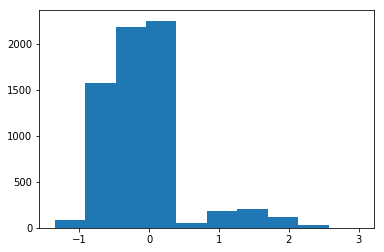

In [83]:
plt.figure()
plt.hist(sppm_results.resid_deviance)
plt.show()

## Simple Poisson player minutes model

### Preparing data

In [84]:
sppmm_df = element_gameweek_df.copy()

In [85]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [86]:
sppmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [87]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [88]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [89]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'assists')

In [90]:
sppmm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_581', 'element_585', 'element_586', 'element_587',
       'element_588', 'element_589', 'element_590', 'element_591',
       'element_592', 'log_minutes'],
      dtype='object', length=467)

### Fitting model

In [91]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [92]:
print(sppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6208
Model Family:                 Poisson   Df Model:                          466
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1708.0
Date:                Sat, 16 Mar 2019   Deviance:                       2210.6
Time:                        16:03:43   Pearson chi2:                 4.07e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -30.9479   2.49e+05     -0.000      1.000   -4.89e+05    4.89e+05
opposition_team_2      0.205

### Model fit

In [93]:
sppmm_results.aic

4349.995664516023

In [94]:
sppmm_results.bic

-52457.866688693655

In [95]:
sppmm_pearson_results = goodness_fit.pearson_chi_squared_test(sppmm_results)
sppmm_pearson_results

(False, 1.0)

In [96]:
sppmm_results.resid_deviance.describe()

count    6673.000000
mean       -0.150638
std         0.555538
min        -1.401454
25%        -0.472166
50%        -0.272765
75%        -0.000001
max         2.989446
dtype: float64

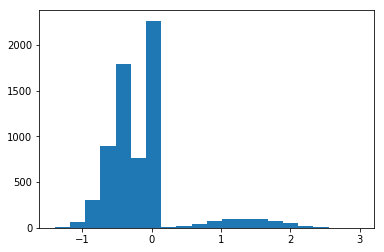

In [97]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.show()

## Simple Poisson player exposure model

### Preparing data

In [98]:
eppmm_df = element_gameweek_df.copy()

In [99]:
eppmm_df = player.add_categorical_variables(eppmm_df, 'opposition_team')
eppmm_df = player.add_categorical_variables(eppmm_df, 'element')

In [100]:
eppmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [101]:
eppmm_exposure = eppmm_df['minutes']

In [102]:
eppmm_df = player.remove_redundant_columns(eppmm_df, eppmm_redundant_columns)

In [103]:
eppmm_response_df, eppmm_explanatory_df = player.get_response_explanatory_dfs(eppmm_df, 'assists')

In [104]:
eppmm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_580', 'element_581', 'element_585', 'element_586',
       'element_587', 'element_588', 'element_589', 'element_590',
       'element_591', 'element_592'],
      dtype='object', length=466)

### Fitting model

In [105]:
eppmm_results = sm.GLM(
    eppmm_response_df,
    eppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop',
    exposure=eppmm_exposure
).fit()

In [106]:
print(eppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 6675
Model:                            GLM   Df Residuals:                     6209
Model Family:                 Poisson   Df Model:                          465
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1712.8
Date:                Sat, 16 Mar 2019   Deviance:                       2220.2
Time:                        16:03:58   Pearson chi2:                 4.47e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -32.3097   2.45e+05     -0.000      1.000    -4.8e+05     4.8e+05
opposition_team_2      0.195

### Model fit

In [107]:
eppmm_results.aic

4357.6681333468905

In [108]:
eppmm_results.bic

-52457.00034434606

In [109]:
eppmm_pearson_results = goodness_fit.pearson_chi_squared_test(eppmm_results)
eppmm_pearson_results

(False, 1.0)

In [110]:
eppmm_results.resid_deviance.describe()

count    6673.000000
mean       -0.146392
std         0.557973
min        -1.522447
25%        -0.467557
50%        -0.258218
75%        -0.000001
max         2.983596
dtype: float64

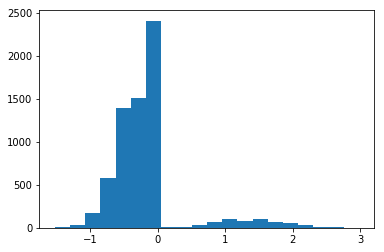

In [111]:
plt.figure()
plt.hist(eppmm_results.resid_deviance, bins=20)
plt.show()

## Simple Gaussian model

### Preparing data

In [112]:
sgm_df = element_gameweek_df.copy()

In [113]:
sgm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [114]:
sgm_df = player.remove_redundant_columns(sgm_df, sgm_redundant_columns)

In [115]:
sgm_response_df, sgm_explanatory_df = player.get_response_explanatory_dfs(sgm_df, 'assists')

### Fitting model

In [116]:
sgm_results = sm.GLM(
    sgm_response_df,
    sgm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [117]:
print(sgm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6673
Model Family:                Gaussian   Df Model:                             1
Link Function:               identity   Scale:              0.10271843445966616
Method:                          IRLS   Log-Likelihood:                 -1875.1
Date:                Sat, 16 Mar 2019   Deviance:                        685.44
Time:                        16:03:59   Pearson chi2:                      685.
No. Iterations:                     2                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0881      0.006     15.880      0.000       0.077       0.099
was_home       0.0153      0.008      1.944

### Model fit

In [118]:
sgm_results.aic

3754.1065545383826

In [119]:
sgm_results.bic

-58077.82856370101

In [120]:
sgm_pearson_results = goodness_fit.pearson_chi_squared_test(sgm_results)
sgm_pearson_results

(False, 1.0)

In [121]:
sgm_results.resid_deviance.describe()

count    6.675000e+03
mean     3.619244e-17
std      3.204732e-01
min     -1.033553e-01
25%     -1.033553e-01
50%     -8.810309e-02
75%     -8.810309e-02
max      2.911897e+00
dtype: float64

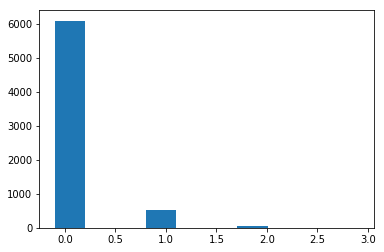

In [122]:
plt.figure()
plt.hist(sgm_results.resid_deviance)
plt.show()

## Simple Gaussian teams model

### Preparing data

In [123]:
sgtm_df = element_gameweek_df.copy()

In [124]:
sgtm_df = player.add_categorical_variables(sgtm_df, 'element_type')
sgtm_df = player.add_categorical_variables(sgtm_df, 'opposition_team')
sgtm_df = player.add_categorical_variables(sgtm_df, 'own_team')

In [125]:
sgtm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team'
]

In [126]:
sgtm_df = player.remove_redundant_columns(sgtm_df, sgtm_redundant_columns)

In [127]:
sgtm_response_df, sgtm_explanatory_df = player.get_response_explanatory_dfs(sgtm_df, 'assists')

In [128]:
sgtm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20'],
      dtype='object')

In [129]:
sgtm_response_df.head()

76    0
78    0
79    0
80    0
81    0
Name: assists, dtype: int64

### Fitting model

In [130]:
sgtm_results = sm.GLM(
    sgtm_response_df,
    sgtm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [131]:
print(sgtm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6633
Model Family:                Gaussian   Df Model:                            41
Link Function:               identity   Scale:              0.10062820843655543
Method:                          IRLS   Log-Likelihood:                 -1786.4
Date:                Sat, 16 Mar 2019   Deviance:                        667.47
Time:                        16:03:59   Pearson chi2:                      667.
No. Iterations:                     2                                          
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1106      0.026      4.284      0.000       0.060       0.161
was_home           

### Model fit

In [132]:
sgtm_results.aic

3656.7429799400124

In [133]:
sgtm_results.bic

-57743.55679095995

In [134]:
sgtm_pearson_results = goodness_fit.pearson_chi_squared_test(sgtm_results)
sgtm_pearson_results

(False, 1.0)

In [135]:
sgtm_results.resid_deviance.describe()

count    6.675000e+03
mean     7.781374e-16
std      3.162436e-01
min     -2.689460e-01
25%     -1.225854e-01
50%     -8.550588e-02
75%     -4.255650e-02
max      2.852379e+00
dtype: float64

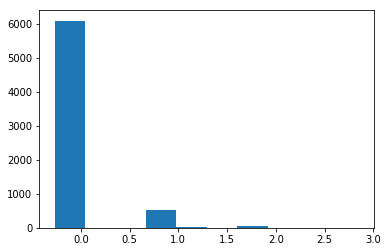

In [136]:
plt.figure()
plt.hist(sgtm_results.resid_deviance)
plt.show()

## Simple Gaussian teams minutes model

### Preparing data

In [153]:
sgtmm_df = element_gameweek_df.copy()

In [154]:
sgtmm_df = player.add_categorical_variables(sgtmm_df, 'element_type')
sgtmm_df = player.add_categorical_variables(sgtmm_df, 'opposition_team')
sgtmm_df = player.add_categorical_variables(sgtmm_df, 'own_team')

In [155]:
sgtmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'minutes'
]

In [156]:
sgtmm_df['log_minutes'] = np.log(sgtmm_df['minutes'])

In [157]:
sgtmm_df = player.remove_redundant_columns(sgtmm_df, sgtmm_redundant_columns)

In [158]:
sgtmm_response_df, sgtmm_explanatory_df = player.get_response_explanatory_dfs(sgtmm_df, 'assists')

In [159]:
sgtmm_explanatory_df.columns

Index(['const', 'was_home', 'element_type_3', 'element_type_4',
       'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       'opposition_team_11', 'opposition_team_12', 'opposition_team_13',
       'opposition_team_14', 'opposition_team_15', 'opposition_team_16',
       'opposition_team_17', 'opposition_team_18', 'opposition_team_19',
       'opposition_team_20', 'own_team_2', 'own_team_3', 'own_team_4',
       'own_team_5', 'own_team_6', 'own_team_7', 'own_team_8', 'own_team_9',
       'own_team_10', 'own_team_11', 'own_team_12', 'own_team_13',
       'own_team_14', 'own_team_15', 'own_team_16', 'own_team_17',
       'own_team_18', 'own_team_19', 'own_team_20', 'log_minutes'],
      dtype='object')

### Fitting model

In [160]:
sgtmm_results = sm.GLM(
    sgtmm_response_df,
    sgtmm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [161]:
print(sgtmm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6632
Model Family:                Gaussian   Df Model:                            42
Link Function:               identity   Scale:              0.09942574571267358
Method:                          IRLS   Log-Likelihood:                 -1745.7
Date:                Sat, 16 Mar 2019   Deviance:                        659.39
Time:                        16:33:54   Pearson chi2:                      659.
No. Iterations:                     2                                          
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0579      0.032     -1.823      0.068      -0.120       0.004
was_home           

### Model fit

In [162]:
sgtmm_results.aic

3577.492866053828

In [163]:
sgtmm_results.bic

-57742.826027469906

In [164]:
sgtmm_pearson_results = goodness_fit.pearson_chi_squared_test(sgtmm_results)
sgtmm_pearson_results

(False, 1.0)

In [165]:
sgtmm_results.resid_deviance.describe()

count    6.675000e+03
mean    -2.232288e-15
std      3.143248e-01
min     -2.816265e-01
25%     -1.285957e-01
50%     -8.526928e-02
75%     -3.741746e-02
max      2.839478e+00
dtype: float64

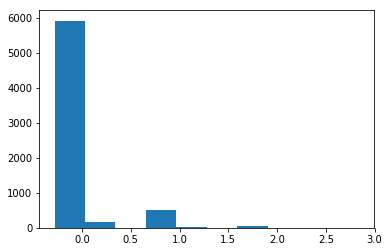

In [166]:
plt.figure()
plt.hist(sgtmm_results.resid_deviance)
plt.show()

## Simple Gaussian player model

### Preparing data

In [137]:
sgpm_df = element_gameweek_df.copy()

In [138]:
sgpm_df = player.add_categorical_variables(sgpm_df, 'opposition_team')
sgpm_df = player.add_categorical_variables(sgpm_df, 'element')

In [139]:
sgpm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home'
]

In [140]:
sgpm_df = player.remove_redundant_columns(sgpm_df, sgpm_redundant_columns)

In [141]:
sgpm_response_df, sgpm_explanatory_df = player.get_response_explanatory_dfs(sgpm_df, 'assists')

In [142]:
sgpm_explanatory_df.columns

Index(['const', 'opposition_team_2', 'opposition_team_3', 'opposition_team_4',
       'opposition_team_5', 'opposition_team_6', 'opposition_team_7',
       'opposition_team_8', 'opposition_team_9', 'opposition_team_10',
       ...
       'element_580', 'element_581', 'element_585', 'element_586',
       'element_587', 'element_588', 'element_589', 'element_590',
       'element_591', 'element_592'],
      dtype='object', length=466)

### Fitting model

In [143]:
sgpm_results = sm.GLM(
    sgpm_response_df,
    sgpm_explanatory_df,
    family=sm.families.Gaussian(),
    missing='drop'
).fit()

In [144]:
print(sgpm_results.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                  6675
Model:                            GLM   Df Residuals:                      6209
Model Family:                Gaussian   Df Model:                           465
Link Function:               identity   Scale:              0.09679049661411573
Method:                          IRLS   Log-Likelihood:                 -1436.1
Date:                Sat, 16 Mar 2019   Deviance:                        600.97
Time:                        16:04:02   Pearson chi2:                      601.
No. Iterations:                     2                                          
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0010      0.112      0.009      0.993      -0.218       0.220
opposition_team_2  

### Model fit

In [145]:
sgpm_results.aic

3804.2608404968996

In [146]:
sgpm_results.bic

-54076.254723136764

In [147]:
sgpm_pearson_results = goodness_fit.pearson_chi_squared_test(sgpm_results)
sgpm_pearson_results

(False, 1.0)

In [148]:
sgpm_results.resid_deviance.describe()

count    6.675000e+03
mean     8.813591e-17
std      3.000780e-01
min     -9.870271e-01
25%     -1.217896e-01
50%     -4.503206e-02
75%      6.270069e-03
max      2.579526e+00
dtype: float64

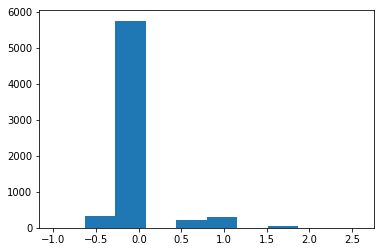

In [149]:
plt.figure()
plt.hist(sgpm_results.resid_deviance)
plt.show()

# Model comparison

In [167]:
{
    'simple Poisson': spm_results.aic,
    'simple Poisson teams': sptm_results.aic,
    'simple Poisson players': sppm_results.aic,
    'simple Poisson minutes': spmm_results.aic,
    'simple Poisson teams minutes': sptmm_results.aic,
    'simple Poisson players minutes': sppmm_results.aic,
    'simple Poisson players exposure': eppmm_results.aic,
    'simple Gaussian': sgm_results.aic,
    'simple Gaussian teams': sgtm_results.aic,
    'simple Gaussian teams minutes': sgtmm_results.aic,
    'simple Gaussian players': sgpm_results.aic
}

{'simple Poisson': 4352.178364133257,
 'simple Poisson teams': 4240.051792760612,
 'simple Poisson players': 4420.032929799021,
 'simple Poisson minutes': 4279.310891747676,
 'simple Poisson teams minutes': 4131.430362795217,
 'simple Poisson players minutes': 4349.995664516023,
 'simple Poisson players exposure': 4357.6681333468905,
 'simple Gaussian': 3754.1065545383826,
 'simple Gaussian teams': 3656.7429799400124,
 'simple Gaussian teams minutes': 3577.492866053828,
 'simple Gaussian players': 3804.2608404968996}

AIC prefers Gaussian models, particularly simple Gaussian teams minutes

In [168]:
{
    'simple Poisson': spm_results.bic,
    'simple Poisson teams': sptm_results.bic,
    'simple Poisson players': sppm_results.bic,
    'simple Poisson minutes': spmm_results.bic,
    'simple Poisson teams minutes': sptmm_results.bic,
    'simple Poisson players minutes': sppmm_results.bic,
    'simple Poisson players exposure': eppmm_results.bic,    
    'simple Gaussian': sgm_results.bic,
    'simple Gaussian teams': sgtm_results.bic,
    'simple Gaussian teams minutes': sgtmm_results.bic,
    'simple Gaussian players': sgpm_results.bic
}

{'simple Poisson': -55627.337998279516,
 'simple Poisson teams': -55460.41346583815,
 'simple Poisson players': -52394.63554789392,
 'simple Poisson minutes': -55693.399346181825,
 'simple Poisson teams minutes': -55562.22877132028,
 'simple Poisson players minutes': -52457.866688693655,
 'simple Poisson players exposure': -52457.00034434606,
 'simple Gaussian': -58077.82856370101,
 'simple Gaussian teams': -57743.55679095995,
 'simple Gaussian teams minutes': -57742.826027469906,
 'simple Gaussian players': -54076.254723136764}

BIC prefers Gaussian models, particularly simple Gaussian

In [169]:
{
    'simple Poisson': spm_pearson_results,
    'simple Poisson teams': sptm_pearson_results,
    'simple Poisson players': sppm_pearson_results,
    'simple Poisson minutes': spmm_pearson_results,
    'simple Poisson teams minutes': sptmm_pearson_results,
    'simple Poisson players minutes': sppmm_pearson_results,
    'simple Poisson players exposure': eppmm_pearson_results,
    'simple Gaussian': sgm_pearson_results,
    'simple Gaussian teams': sgtm_pearson_results,
    'simple Gaussian teams minutes': sgtmm_pearson_results,
    'simple Gaussian players': sgpm_pearson_results
}

{'simple Poisson': (True, 1.671410863912648e-05),
 'simple Poisson teams': (True, 0.022029767090219976),
 'simple Poisson players': (False, 1.0),
 'simple Poisson minutes': (True, 0.004605590251514968),
 'simple Poisson teams minutes': (False, 0.28194871722764203),
 'simple Poisson players minutes': (False, 1.0),
 'simple Poisson players exposure': (False, 1.0),
 'simple Gaussian': (False, 1.0),
 'simple Gaussian teams': (False, 1.0),
 'simple Gaussian teams minutes': (False, 1.0),
 'simple Gaussian players': (False, 1.0)}

Gaussian models fit. Poisson minutes and player models fit.